In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the stock symbols and the time period
stocks = ['GOOGL', 'AMZN', 'TSLA']
start_date = '2014-11-27'
end_date = '2024-11-27'

# Fetch historical data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
data = data.dropna()


[*********************100%***********************]  3 of 3 completed


In [ ]:
# Calculate daily returns
daily_returns = data.pct_change().dropna()

In [ ]:
# Calculate annual daily mean return
mean_daily_returns = daily_returns.mean()
annual_mean_returns = mean_daily_returns * 252  # Assuming 252 trading days in a year

# Calculate daily standard deviation
daily_std = daily_returns.std()
annual_std = daily_std * np.sqrt(252)

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Calculate Sharpe Ratio (assuming risk-free rate of 0.01)
risk_free_rate = 0.01
sharpe_ratios = (annual_mean_returns - risk_free_rate) / annual_std

# Display results
print("Annual Mean Returns:\n", annual_mean_returns)
print("Annual Standard Deviation:\n", annual_std)
print("Correlation Matrix:\n", correlation_matrix)
print("Sharpe Ratios:\n", sharpe_ratios)


Annual Mean Returns:
 Ticker
AMZN     0.304305
GOOGL    0.222949
TSLA     0.466422
dtype: float64
Annual Standard Deviation:
 Ticker
AMZN     0.327811
GOOGL    0.283671
TSLA     0.569650
dtype: float64
Correlation Matrix:
 Ticker      AMZN     GOOGL      TSLA
Ticker                              
AMZN    1.000000  0.645269  0.386763
GOOGL   0.645269  1.000000  0.362907
TSLA    0.386763  0.362907  1.000000
Sharpe Ratios:
 Ticker
AMZN     0.897787
GOOGL    0.750688
TSLA     0.801232
dtype: float64


In [ ]:
# Function to calculate portfolio performance
def portfolio_performance(weights):
    portfolio_return = np.sum(annual_mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))
    return portfolio_return, portfolio_std

# Generate random portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)  # Normalize to sum to 1
    weights_record.append(weights)
    portfolio_return, portfolio_std = portfolio_performance(weights)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std
    results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std  # Sharpe Ratio

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe'])


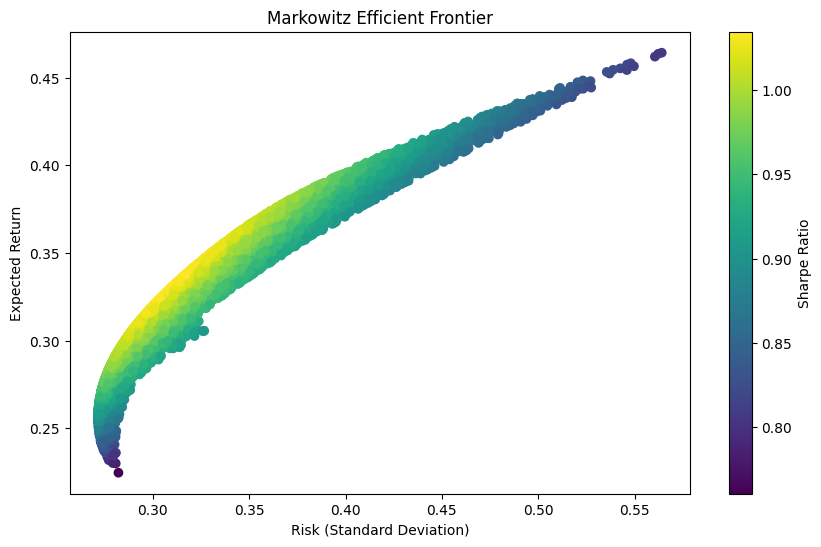

In [ ]:
# Plotting the Markowitz frontier
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.title('Markowitz Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.show()


In [ ]:
# Find the optimal portfolio (maximum Sharpe ratio)
max_sharpe_idx = results_df['Sharpe'].idxmax()
optimal_weights = weights_record[max_sharpe_idx]
optimal_return = results_df['Return'][max_sharpe_idx]
optimal_risk = results_df['Risk'][max_sharpe_idx]

print("Optimal Portfolio Weights:\n", optimal_weights)
print("Max Return:", optimal_return)
print("Associated Risk:", optimal_risk)

# Compute minimum standard deviation portfolio
min_std_idx = results_df['Risk'].idxmin()
min_std_weights = weights_record[min_std_idx]
min_std_return = results_df['Return'][min_std_idx]
min_std_risk = results_df['Risk'][min_std_idx]

print("Min Std Portfolio Weights:\n", min_std_weights)
print("Min Std Return:", min_std_return)
print("Associated Risk:", min_std_risk)

# Compute a range of returns
range_returns = np.linspace(min_std_return, optimal_return, 10)
associated_risks = []

for target_return in range_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x)[0] - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    result = minimize(lambda x: portfolio_performance(x)[1],
                      len(stocks) * [1. / len(stocks)],
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    associated_risks.append(result.fun)

# Display range returns and associated risks
for r, risk in zip(range_returns, associated_risks):
    print(f"Target Return: {r:.4f}, Associated Risk: {risk:.4f}")


Optimal Portfolio Weights:
 [0.52531628 0.20738345 0.26730027]
Max Return: 0.33076675206606865
Associated Risk: 0.31009505072710647
Min Std Portfolio Weights:
 [0.27150713 0.68839134 0.04010152]
Min Std Return: 0.2548010013352965
Associated Risk: 0.2716924292377292
Target Return: 0.2548, Associated Risk: 0.2717
Target Return: 0.2632, Associated Risk: 0.2721
Target Return: 0.2717, Associated Risk: 0.2735
Target Return: 0.2801, Associated Risk: 0.2759
Target Return: 0.2886, Associated Risk: 0.2793
Target Return: 0.2970, Associated Risk: 0.2837
Target Return: 0.3054, Associated Risk: 0.2891
Target Return: 0.3139, Associated Risk: 0.2953
Target Return: 0.3223, Associated Risk: 0.3023
Target Return: 0.3308, Associated Risk: 0.3101


In [ ]:
weights_index = pd.Series(optimal_weights, index=stocks)
print("Weights Index for Optimal Portfolio:\n", weights_index)


Weights Index for Optimal Portfolio:
 GOOGL    0.525316
AMZN     0.207383
TSLA     0.267300
dtype: float64
